In [82]:
import pandas as pd
import numpy as np
import seaborn as sns

PATH_READ = '123181_train_raw.csv'
PATH_WRITE = '123181_train_withF.csv'
# df = pd.read_csv(PATH_READ, index_col='Timestamp')
df = pd.read_csv(PATH_READ)


Preprocessing, cleaning unwanted cols

In [83]:
df = df.drop(['InstrumentID','TradingDay','PreClosePrice',], axis=1)
# df.index = pd.to_datetime(df.index)

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close'], dtype='object')


Add hist return features

In [84]:
def hist_ret_close(df, param):
    return df['Close'] / df['Close'].shift(param)

df.insert(loc=df.columns.get_loc('Close')+1, column= 'Hist_Ret_Close_15min', value= hist_ret_close(df,15))
df.insert(loc=df.columns.get_loc('Close')+1, column= 'Hist_Ret_Close_10min', value= hist_ret_close(df,10))
df.insert(loc=df.columns.get_loc('Close')+1, column= 'Hist_Ret_Close_5min', value= hist_ret_close(df,5))
df.insert(loc=df.columns.get_loc('Close')+1, column= 'Hist_Ret_Close_3min', value= hist_ret_close(df,3))

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'Hist_Ret_Close_3min', 'Hist_Ret_Close_5min', 'Hist_Ret_Close_10min',
       'Hist_Ret_Close_15min'],
      dtype='object')


Add log return features

In [85]:
df['Log_Return_Close_1min'] = np.log(df['Close'] / df['Close'].shift(1))

print(df.columns)
print(df['Log_Return_Close_1min'])

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'Hist_Ret_Close_3min', 'Hist_Ret_Close_5min', 'Hist_Ret_Close_10min',
       'Hist_Ret_Close_15min', 'Log_Return_Close_1min'],
      dtype='object')
0            NaN
1       0.002370
2      -0.003013
3       0.003482
4       0.005856
          ...   
5835    0.000184
5836    0.000000
5837    0.000000
5838   -0.000303
5839    0.000000
Name: Log_Return_Close_1min, Length: 5840, dtype: float64


Add average price and mean price from 4

In [86]:
df['Avg'] = df['Turnover']/df['Volume']

# For unchanged prices, fill zero

# 目前对于涨/跌停这种情况的策略是在数据里补0，也许可以用NaN然后删除？
# df['AvgPrice'].fillna(0, inplace=True)


nan_rows_Avg = df[df['Avg'].isnull()]

# 如遇涨/跌停，直接用高开低收的价格，因为都一样
for index, row in nan_rows_Avg.iterrows():
    if row['High'] == row['Low'] == row['Open'] == row['Close']:
        row['Avg'] = row['High']

df.update(nan_rows_Avg)

print(df)

df['4meanPrice'] = (df['High']+df['Low']+df['Close']+df['Open'])/4.0


                Timestamp     Open     High      Low    Volume     Turnover  \
0     2023-06-01 09:26:00  161.800  161.800  161.800    6900.0   1116420.00   
1     2023-06-01 09:31:00  161.580  162.184  161.000   61100.0   9883344.91   
2     2023-06-01 09:32:00  162.324  163.221  161.601  102460.0  16637773.53   
3     2023-06-01 09:33:00  161.605  162.260  161.341   38490.0   6225348.15   
4     2023-06-01 09:34:00  162.572  163.740  162.490  115630.0  18865071.86   
...                   ...      ...      ...      ...       ...          ...   
5835  2023-07-06 14:58:00  303.521  303.592  303.521    1860.0    564560.61   
5836  2023-07-06 14:59:00  303.592  303.592  303.592       0.0         0.00   
5837  2023-07-06 15:00:00  303.592  303.592  303.592       0.0         0.00   
5838  2023-07-06 15:01:00  303.500  303.500  303.500   53090.0  16112815.00   
5839  2023-07-06 15:35:00  303.500  303.500  303.500       0.0         0.00   

        Close  Hist_Ret_Close_3min  Hist_Ret_Close_

Add log return based on Avg

In [87]:
df['Log_Return_Avg_1min'] = np.log(df['Avg'] / df['Avg'].shift(1))

print(df.columns)
print(df['Log_Return_Avg_1min'])

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'Hist_Ret_Close_3min', 'Hist_Ret_Close_5min', 'Hist_Ret_Close_10min',
       'Hist_Ret_Close_15min', 'Log_Return_Close_1min', 'Avg', '4meanPrice',
       'Log_Return_Avg_1min'],
      dtype='object')
0            NaN
1      -0.000267
2       0.003864
3      -0.003972
4       0.008686
          ...   
5835   -0.000055
5836         NaN
5837         NaN
5838         NaN
5839         NaN
Name: Log_Return_Avg_1min, Length: 5840, dtype: float64


Hist based on avg price

In [88]:
def hist_ret_avg(df, param):
    return df['Avg'] / df['Avg'].shift(param)

df['Hist_Ret_Avg_3min'] = hist_ret_avg(df, 3)
df['Hist_Ret_Avg_5min'] = hist_ret_avg(df, 5)
df['Hist_Ret_Avg_10min'] = hist_ret_avg(df, 10)
df['Hist_Ret_Avg_15min'] = hist_ret_avg(df, 15)

Add targets based on close price

In [89]:
df['Target_Close_1min'] = (df['Close'].shift(-1) - df['Close'])/df['Close']

df['Target_Close_5min_Mean'] = (df['Close'].rolling(window=5).mean().shift(-5) - df['Close']) / df['Close']

df['Target_Close_10min_Mean'] = (df['Close'].rolling(window=10).mean().shift(-10) - df['Close']) / df['Close']

df['Target_Close_15min_Mean'] = (df['Close'].rolling(window=10).mean().shift(-15) - df['Close']) / df['Close']

Add targets based on avg price

In [90]:
df['Target_Avg_1min'] = (df['Avg'].shift(-1) - df['Avg'])/df['Avg']

df['Target_Avg_5min_Mean'] = (df['Avg'].rolling(window=5).mean().shift(-5) - df['Avg']) / df['Avg']

df['Target_Avg_10min_Mean'] = (df['Avg'].rolling(window=10).mean().shift(-10) - df['Avg']) / df['Avg']

df['Target_Avg_15min_Mean'] = (df['Avg'].rolling(window=10).mean().shift(-15) - df['Avg']) / df['Avg']

Experiment with rolling volatility

In [91]:
def rolling_std(df, window_size):
    return df['Close'].rolling(window=window_size).std()

df['Vol_5min_Close'] = rolling_std(df, 5)
df['Vol_10min_Close'] = rolling_std(df, 10)
df['Vol_15min_Close'] = rolling_std(df, 15)

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'Hist_Ret_Close_3min', 'Hist_Ret_Close_5min', 'Hist_Ret_Close_10min',
       'Hist_Ret_Close_15min', 'Log_Return_Close_1min', 'Avg', '4meanPrice',
       'Log_Return_Avg_1min', 'Hist_Ret_Avg_3min', 'Hist_Ret_Avg_5min',
       'Hist_Ret_Avg_10min', 'Hist_Ret_Avg_15min', 'Target_Close_1min',
       'Target_Close_5min_Mean', 'Target_Close_10min_Mean',
       'Target_Close_15min_Mean', 'Target_Avg_1min', 'Target_Avg_5min_Mean',
       'Target_Avg_10min_Mean', 'Target_Avg_15min_Mean', 'Vol_5min_Close',
       'Vol_10min_Close', 'Vol_15min_Close'],
      dtype='object')


BOP = [(Close-Open)/(High-Low)]*Volume

In [92]:
df['BOP'] = ((df['Close']-df['Open']) / (df['High']-df['Low']))

print(df['BOP'])

0            NaN
1       0.510135
2      -0.387654
3       0.712731
4       0.512800
          ...   
5835    1.000000
5836         NaN
5837         NaN
5838         NaN
5839         NaN
Name: BOP, Length: 5840, dtype: float64


Average True Range

In [93]:
df['High-Low'] = df['High'] - df['Low']
df['High-Close_prev'] = abs(df['High'] - df['Close'].shift(1))
df['Low-Close_prev'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['High-Low', 'High-Close_prev', 'Low-Close_prev']].max(axis=1)

# Choose the ATR period
ATR_period = 16

# Calculate Average True Range (ATR)
df['ATR_16'] = df['TR'].rolling(ATR_period).mean()

# Drop the intermediate columns used for TR calculation
df.drop(['High-Low', 'High-Close_prev', 'Low-Close_prev'], axis=1, inplace=True)

Add Triple Barrier Target

<Axes: >

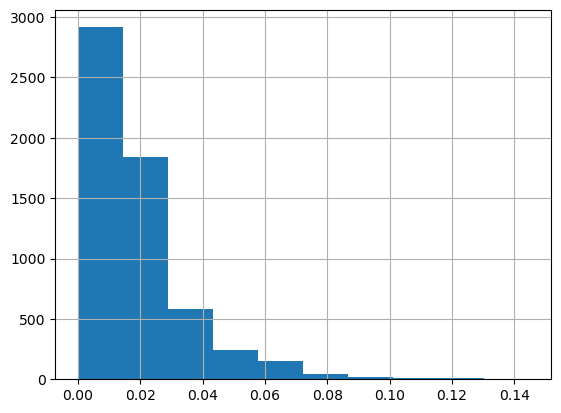

In [94]:
df['15min_range'] = df['High'].rolling(15).max() - df['Low'].rolling(15).min()
(df['15min_range'] /df['High']).hist()

In [95]:
def getDailyVol(data, span=30):
    df = data.assign(Return = lambda x: data['Close'] / data['Close'].shift(1)-1)
    sigma = df['Return'].ewm(span=span).std()
    return sigma

vol = getDailyVol(data=df)

In [96]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

events = df[['Timestamp']].copy(deep=True)
events['VB'] = df['Timestamp'] + pd.Timedelta(minutes=15)
events['Vol'] = vol

print(events)

               Timestamp                  VB       Vol
0    2023-06-01 09:26:00 2023-06-01 09:41:00       NaN
1    2023-06-01 09:31:00 2023-06-01 09:46:00       NaN
2    2023-06-01 09:32:00 2023-06-01 09:47:00  0.003806
3    2023-06-01 09:33:00 2023-06-01 09:48:00  0.003497
4    2023-06-01 09:34:00 2023-06-01 09:49:00  0.003777
...                  ...                 ...       ...
5835 2023-07-06 14:58:00 2023-07-06 15:13:00  0.001540
5836 2023-07-06 14:59:00 2023-07-06 15:14:00  0.001493
5837 2023-07-06 15:00:00 2023-07-06 15:15:00  0.001447
5838 2023-07-06 15:01:00 2023-07-06 15:16:00  0.001410
5839 2023-07-06 15:35:00 2023-07-06 15:50:00  0.001366

[5840 rows x 3 columns]


In [97]:
def TBL(df, events, width):
    
    res = events[['Timestamp', 'VB']].copy(deep=True)
    
    if width[0] > 0: events['UB'] = width[0]*events['Vol']
    else: events['UB'] = np.nan
        
    if width[1] > 0: events['DB'] = -width[1]*events['Vol']
    else: events['DB'] = np.nan
        
    for col,date,vb in res.itertuples():
        df0 = df[(df['Timestamp'] > date) & (df['Timestamp'] < vb)].copy(deep=True)
        df0['Return'] = df0['Close'] / df.loc[df['Timestamp'] == date, 'Close'].iloc[0]-1
        
        idx = (res['Timestamp'] == date)
        
        res.loc[idx, 'ut'] = df0.loc[df0['Return'] > events.loc[idx,'UB'].iloc[0], 'Timestamp'].min()
        res.loc[idx, 'dt'] = df0.loc[df0['Return'] < events.loc[idx,'DB'].iloc[0], 'Timestamp'].min()
            
    return res

In [98]:
def get_first_touch(df, events, width):
    res = TBL(df, events, width)
    res['First'] = res[['VB', 'ut', 'dt']].dropna(how='all').min(axis=1)
    return res

# 上下栅栏的宽度由 vol(span) * 系数[up,down] 决定
result = get_first_touch(df,events,width = [0.4,0.4])
print(result)

               Timestamp                  VB                  ut  \
0    2023-06-01 09:26:00 2023-06-01 09:41:00                 NaT   
1    2023-06-01 09:31:00 2023-06-01 09:46:00                 NaT   
2    2023-06-01 09:32:00 2023-06-01 09:47:00 2023-06-01 09:33:00   
3    2023-06-01 09:33:00 2023-06-01 09:48:00 2023-06-01 09:34:00   
4    2023-06-01 09:34:00 2023-06-01 09:49:00 2023-06-01 09:38:00   
...                  ...                 ...                 ...   
5835 2023-07-06 14:58:00 2023-07-06 15:13:00                 NaT   
5836 2023-07-06 14:59:00 2023-07-06 15:14:00                 NaT   
5837 2023-07-06 15:00:00 2023-07-06 15:15:00                 NaT   
5838 2023-07-06 15:01:00 2023-07-06 15:16:00                 NaT   
5839 2023-07-06 15:35:00 2023-07-06 15:50:00                 NaT   

                      dt               First  
0                    NaT 2023-06-01 09:41:00  
1                    NaT 2023-06-01 09:46:00  
2                    NaT 2023-06-01 09:33:

In [99]:
def get_label(df,result):
    result = result.dropna(subset=['First'])
    outcome = result[['Timestamp']].copy(deep=True)
    
    price_t0 = pd.merge(result,df,on=['Timestamp'],how='left')['Close']
    price_t1 = pd.merge(result,df,left_on=['First'], right_on=['Timestamp'], how = 'left')['Close']
    
    outcome['Return'] = price_t1/price_t0-1
    outcome['TB_15min_Label'] = np.sign(outcome['Return'].dropna())
    
    outcome = outcome.drop(['Return'], axis = 1)

    return outcome

outcome = get_label(df,result)
print(outcome)

df = pd.merge(df,outcome, on=['Timestamp'],how='inner')

               Timestamp  TB_15min_Label
0    2023-06-01 09:26:00             1.0
1    2023-06-01 09:31:00             1.0
2    2023-06-01 09:32:00             1.0
3    2023-06-01 09:33:00             1.0
4    2023-06-01 09:34:00            -1.0
...                  ...             ...
5835 2023-07-06 14:58:00             NaN
5836 2023-07-06 14:59:00             NaN
5837 2023-07-06 15:00:00             NaN
5838 2023-07-06 15:01:00             NaN
5839 2023-07-06 15:35:00             NaN

[5840 rows x 2 columns]


Cleaning NaN and unwanted data

In [100]:
print('Number of rows before cleaning: %d'%df.shape[0])

df.index = df['Timestamp']
df = df.drop(['Timestamp'], axis=1)

df = df[(df['Target_Close_1min'] != 0)
                      & (df['Target_Close_5min_Mean'] != 0)
                      & (df['Target_Close_10min_Mean'] != 0)
                      & (df['Target_Close_15min_Mean'] != 0)
                     ]
pd.set_option ('mode.use_inf_as_na', True)
df = df.dropna()


print('Number of rows after cleaning: %d'%df.shape[0])

print(df)

Number of rows before cleaning: 5840
Number of rows after cleaning: 4826
                        Open     High      Low   Volume     Turnover    Close  \
Timestamp                                                                       
2023-06-01 09:45:00  164.447  164.883  163.664  66850.0  10992018.33  163.664   
2023-06-01 09:46:00  163.510  163.689  163.269  56180.0   9185431.13  163.348   
2023-06-01 09:47:00  163.379  163.684  162.892  45340.0   7400842.01  162.892   
2023-06-01 09:48:00  162.819  163.449  162.802  58240.0   9503958.08  163.272   
2023-06-01 09:49:00  163.381  163.500  163.219  15950.0   2605439.91  163.330   
...                      ...      ...      ...      ...          ...      ...   
2023-07-06 14:39:00  299.800  300.263  299.800  10430.0   3129620.72  300.000   
2023-07-06 14:40:00  299.990  300.350  299.802   9600.0   2880003.58  300.099   
2023-07-06 14:41:00  300.200  300.200  299.843   9230.0   2769834.58  300.200   
2023-07-06 14:42:00  300.148  300.33

Saving CSV

In [101]:
df.to_csv(PATH_WRITE)